# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..


In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

# Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

# Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.5,61.0,3.5
1,2020-08-02,0.0,71.0,3.0
2,2020-08-03,0.0,97.5,4.5


# Initialize Parameter

In [7]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
method = RandomWalk(n_observations = df_obs.shape[0], device=device, dtype=dtype)
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

# Optimization

Step: 0, Learning Rate: 0.00999 Time: 0.162, Comparison Loss: 114078.5859375, Phi: 25.0 


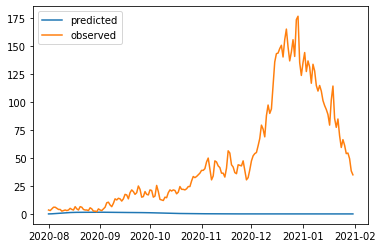

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1089, Comparison Loss: 101628.4765625, Phi: 24.87941551208496 
Step: 100, Learning Rate: 0.009038873549665948 Time: 0.1128, Comparison Loss: 27758.623046875, Phi: 24.781648635864258 


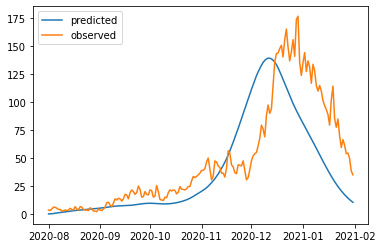

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0605, Comparison Loss: 2711.952392578125, Phi: 24.761577606201172 
Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0598, Comparison Loss: 1407.74853515625, Phi: 24.758258819580078 


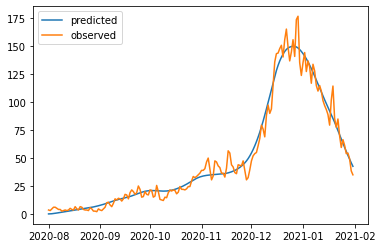

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.0911, Comparison Loss: 1180.939208984375, Phi: 24.756105422973633 
Step: 300, Learning Rate: 0.007399663251239432 Time: 0.0603, Comparison Loss: 1107.26220703125, Phi: 24.754108428955078 


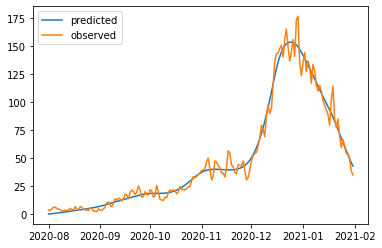

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0603, Comparison Loss: 1074.2337646484375, Phi: 24.75212860107422 
Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0596, Comparison Loss: 1074.1343994140625, Phi: 24.750110626220703 


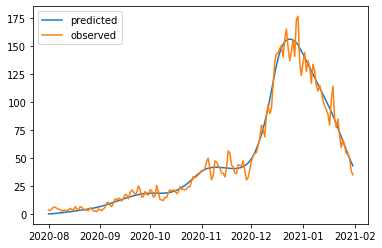

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.065, Comparison Loss: 1043.49755859375, Phi: 24.748079299926758 
Step: 500, Learning Rate: 0.006057725659163231 Time: 0.0603, Comparison Loss: 1035.607177734375, Phi: 24.74604034423828 


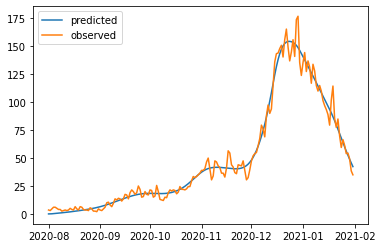

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.0604, Comparison Loss: 1029.76220703125, Phi: 24.743988037109375 
Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0692, Comparison Loss: 1025.2791748046875, Phi: 24.741928100585938 


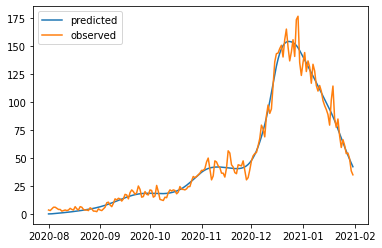

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0582, Comparison Loss: 1021.734375, Phi: 24.739864349365234 
Step: 700, Learning Rate: 0.004959150020176671 Time: 0.0598, Comparison Loss: 1018.855224609375, Phi: 24.737804412841797 


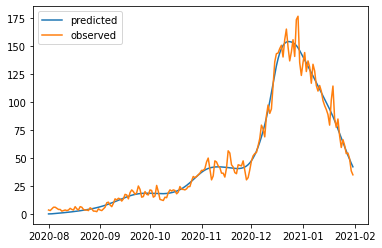

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0608, Comparison Loss: 1016.4638061523438, Phi: 24.73574447631836 
Step: 800, Learning Rate: 0.004486999994614646 Time: 0.0661, Comparison Loss: 1014.4425659179688, Phi: 24.733701705932617 


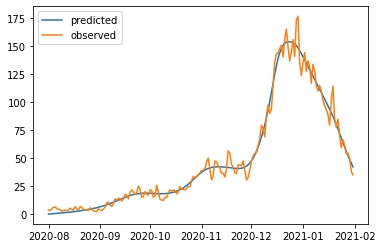

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.0589, Comparison Loss: 1012.7076416015625, Phi: 24.731666564941406 
Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.0601, Comparison Loss: 1011.2026977539062, Phi: 24.72965431213379 


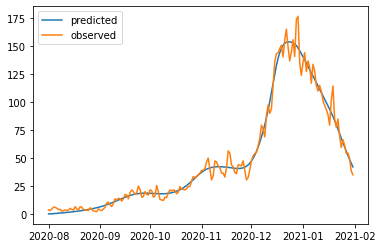

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.0602, Comparison Loss: 1009.8775634765625, Phi: 24.72765350341797 


In [8]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
list_R0 = []
list_sigma = []
list_phi = []
list_alpha = []

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)
  list_R0.append(method.get_R0().item())
  list_sigma.append(method.get_sigma().item())
  list_phi.append(dict_param['real_values']['phi'].item())
  list_alpha.append(dict_param['real_values']['alpha'].item())

  # forward pass
  expected = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss =  calc_mse(expected, observed) * dict_param['real_values']['phi'] # calc_poisson_loss(expected, observed) * dict_param['real_values']['phi'] #
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss}, Phi: {dict_param['real_values']['phi']} ")

    if i % 100==0:
      plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

# Evaluation

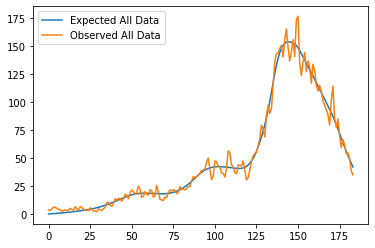

In [9]:
plt.plot(expected.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed.cpu().detach().numpy(),label='Observed All Data')
plt.legend()
plt.show()

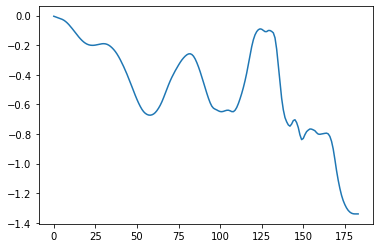

In [10]:
plt.plot(method.get_parameters()[0].cpu().detach().numpy())
plt.show()

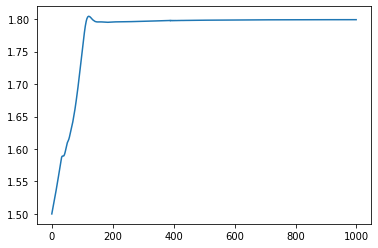

In [11]:
plt.plot(list_R0)

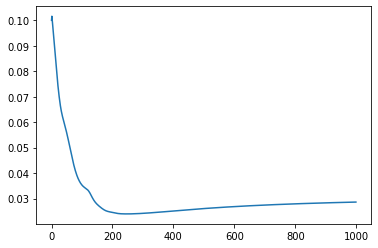

In [12]:
plt.plot(list_sigma)

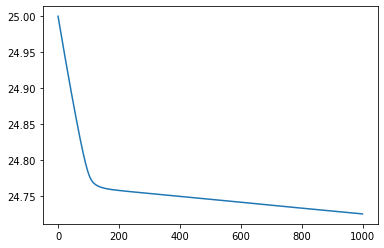

In [13]:
plt.plot(list_phi)

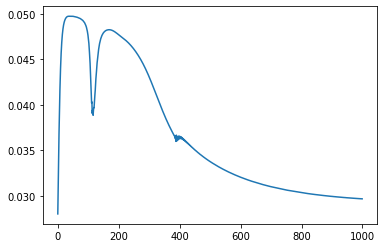

In [14]:
plt.plot(list_alpha)

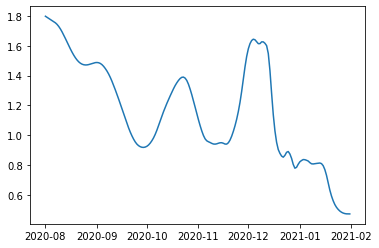

In [15]:
df_rvalue = pd.DataFrame()
df_rvalue['date'] = df_obs.Date
df_rvalue['R_t'] = method.calculate_R().detach().numpy()
df_rvalue.to_csv('data/inferred_rvalue.csv', index=False)
plt.plot(df_rvalue['date'], df_rvalue['R_t'])